## LSTM을 이용한 SINE 함수 예측
  
과목명 | 금융공학  
교수명 | 안재윤 교수님  
제출일 | 2018년 12월 11일  
  
학　번 | 182STG18  
이　름 | 이하경  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sin(x, T = 100):
    return np.sin(2 * np.pi * x / T)

def toy_problem(T = 100, ampl = 0.05):
    x = np.arange(0, 2*T +1) # sequence 0, ..., 200
    noise = ampl * np.random.uniform(low = -1, high = 1, size = len(x))
    return sin(x) + noise

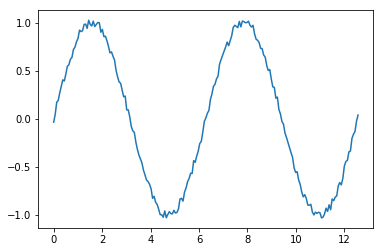

In [3]:
f = toy_problem(T=100, ampl=0.05)
x = np.arange(0, 200 +1) / 200 * 4 * np.pi

plt.plot(x, f)
plt.show()

In [4]:
seq_length = 25

data = []
target = []

for i in range(0, len(x) - seq_length): 
    data.append(f[i:(i+seq_length)])    
    target.append(f[i+seq_length])      
    
X = np.array(data).reshape(len(data), seq_length, 1)
Y = np.array(target).reshape(len(data), 1)                

In [5]:
from sklearn.model_selection import train_test_split

N_train = int(len(data) * 0.9)
N_valid = len(data) - N_train

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = N_valid)

### Modeling

In [6]:
n_in = X.shape[-1]  # X의 feature(variable)의 개수 (=1)
n_out = X.shape[-1] # Y의 class의 개수 (=1)

n_hidden = 100

In [7]:
x = tf.placeholder(tf.float32, [None, seq_length, n_in]) # sequence를 feed
p = tf.placeholder(tf.float32, [None, n_out])            # target을 feed
n_batch = tf.placeholder(tf.int32)

In [8]:
def get_variable(name, shape):
    return tf.get_variable(name, shape, tf.float32,
                           initializer = tf.contrib.layers.xavier_initializer())

### LSTM Cell :

In [9]:
############### hidden state ###############
Wxh = get_variable('Wxh', [n_in, n_hidden])
Whh = get_variable('Wh', [n_hidden, n_hidden])
Wh = tf.concat([Wxh, Whh], axis = 0)
bh = get_variable('bh', [n_hidden])

############### memory state ###############
Wxc = get_variable('Wxc', [n_in, n_hidden])
Whc = get_variable('Whc', [n_hidden, n_hidden])
Wc = tf.concat([Wxc, Whc], axis = 0)
bc = get_variable('bc', [n_hidden])

############### input gate ###############
Wxu =  get_variable('Wxu', [n_in, n_hidden])
Whu = get_variable('Whu', [n_hidden, n_hidden])
Wu = tf.concat([Wxu, Whu], axis = 0)
bu = get_variable('bu', [n_hidden])

############### forget gate ###############
Wxf = get_variable('Wxf', [n_in, n_hidden])
Whf = get_variable('Whf', [n_hidden, n_hidden])
Wf = tf.concat([Wxf, Whf], axis = 0)
bf = get_variable('bf', [n_hidden])

############### output gate ###############
Wxo = get_variable('Wxo', [n_in, n_hidden])
Who = get_variable('Who', [n_hidden, n_hidden])
Wo = tf.concat([Wxo, Who], axis = 0)
bo = get_variable('bo', [n_hidden])

############### more step ###############
Why = get_variable('Why', [n_hidden, 1])
by = get_variable('by', [1])

W = get_variable('W', [1, n_out]) # linear
b = get_variable('b', [n_out])        

In [10]:
init_state = tf.zeros([n_batch, n_hidden], tf.float32)
hidden = init_state
memory = init_state

y_hats = []
hiddens = []
memorys = []

x_ = tf.unstack(x, axis = 1)
for t, x_t in enumerate(x_):
    
    hx = tf.concat([x_t, hidden], axis = 1)                                # 이전 시점의 hidden state를 받아옴
    
    memory_new = tf.tanh( tf.matmul(hx, Wc) + bc )
    tau_u = tf.sigmoid( tf.matmul(hx, Wu) + bu )
    tau_f = tf.sigmoid( tf.matmul(hx, Wf) + bf )
    tau_o = tf.sigmoid( tf.matmul(hx, Wo) + bo )

    memory = tf.multiply(tau_u, memory_new) + tf.multiply(tau_f, memory)   # 이전 시점의 memory state 값과 
                                                                           # 새로운 memory의 합으로 현재시점의 메모리 계산
    hidden = tf.multiply(tau_o, tf.tanh( memory_new ))
    y_hat = tf.tanh( tf.matmul(hidden, Why) + by )
    
    hiddens.append(hidden)
    memorys.append(memory)
    y_hats.append(y_hat)
    
output = y_hats[-1]
y = tf.matmul(output, W) + b

In [11]:
loss = tf.reduce_mean(tf.square(y - p))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999)
train_step = optimizer.minimize(loss)

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

epochs = 500
batch_size = 10
n_batches = N_train // batch_size

from sklearn.utils import shuffle

my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        sess.run(train_step, feed_dict = {
            x: X_[start:end], p: Y_[start:end], n_batch: batch_size
        })
        val_loss = sess.run(loss, feed_dict = {
            x: X_[start:end], p: Y_[start:end], n_batch: batch_size
        })
        my_loss.append(val_loss)
        
#         if epoch %  10 == 0:
#             print("epoch:", epoch, "current loss:", val_loss)


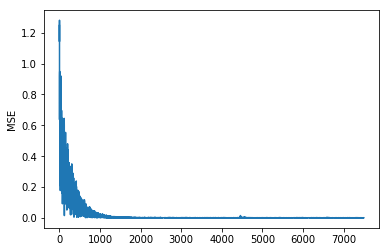

In [13]:
plt.plot(my_loss)
plt.ylabel('MSE')
plt.show()

In [14]:
loss.eval(session = sess, feed_dict = { x: X_train, p: Y_train, n_batch: X_train.shape[0] }) # train

0.00084474747

In [15]:
loss.eval(session = sess, feed_dict = { x: X_valid, p: Y_valid, n_batch: X_valid.shape[0] }) # test

0.0013664048

In [16]:
y_pred = y.eval(session = sess, feed_dict = { x: X, p: Y, n_batch: X.shape[0] })

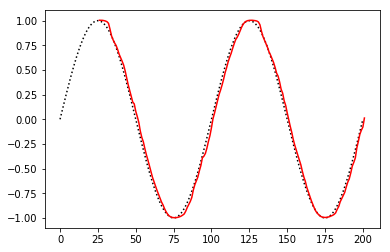

In [17]:
time = np.arange(seq_length+1, (seq_length+X.shape[0]+1))

plt.plot(toy_problem(100, ampl = 0), ':k')
plt.plot(time, y_pred.reshape(y_pred.shape[0]), 'r')
plt.show()